<h1 align=center><font size = 5>Matching Neighbourhoods</font></h1>

### Match an input address to city neighbourhoods in San Francisco, New York, Toronto and London, based on Foursquare venue data

#### Import packages

In [1]:
import os
import wget

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from itertools import chain
 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
from pandas import json_normalize # transform JSON file into a pandas dataframe

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler

import folium

#### Enter Foursquare credentials

In [2]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS = 600 # search radius in meters

#### Transform user-supplied address into location

In [52]:
user_input_address = '175 5th Avenue NYC'
#user_input_address = '45 Rue Greneta, Paris'

geolocator = Nominatim(user_agent="address_converter")
address = geolocator.geocode(user_input_address)
address_loc = pd.DataFrame([user_input_address])
address_loc.columns = ['Neighbourhood']
address_loc['Latitude'] = address.latitude
address_loc['Longitude'] = address.longitude
address_loc['City'] = 'Input'
address_loc

,Neighbourhood,Latitude,Longitude,City
0,175 5th Avenue NYC,40.741059,-73.989642,Input


<a id='item1'></a>


## 1. Extract neighbourhood location data

#### San Francisco

In [6]:
# file name of the json file detailing geographical positions of districts
sf_geo = 'D:\Coursera\san-francisco.geojson'

# open the json file - json.load() methods returns a python dictionary
with open(sf_geo) as sf_file:
    sf_json = json.load(sf_file)

# transform into a dataframe
sf_json_df = json_normalize(sf_json['features']).iloc[:,[2,5]]
sf_json_df['geometry.coordinates'][1] = [item for sublist in sf_json_df['geometry.coordinates'][1] for item in sublist]

In [7]:
# create new dataframe with each json coordinate entry in a separate row
df2 = (sf_json_df['geometry.coordinates'].apply(lambda r: [(i[0],i[1]) for i in r[0]])
           .apply(pd.Series).stack()
           .reset_index(level=1).rename(columns={0:'geometry.coordinates',"level_1":"point"})
           .join(sf_json_df.drop('geometry.coordinates',1), how='left')).reset_index(level=0)

df2[['lng','lat']] = df2['geometry.coordinates'].apply(pd.Series)

In [8]:
# compute mean latitude and longitude values for each neighbourhood
sf_lat = []
sf_lng = []
for i in df2['properties.DISTRICT'].unique():
    sf_lat.append(np.mean(df2[df2['properties.DISTRICT']==i]['lat']))
    sf_lng.append(np.mean(df2[df2['properties.DISTRICT']==i]['lng']))

# create final dataframe with neighbourhoods and mean coordinate values
sf_data = pd.DataFrame(df2['properties.DISTRICT'].unique())
sf_data.columns = ['Neighbourhood']
sf_data['Latitude'] = sf_lat
sf_data['Longitude'] = sf_lng
sf_data['City'] = 'San Francisco'
sf_data.head()

,Neighbourhood,Latitude,Longitude,City
0,CENTRAL,37.804722,-122.413788,San Francisco
1,SOUTHERN,37.783316,-122.394808,San Francisco
2,BAYVIEW,37.741945,-122.384118,San Francisco
3,MISSION,37.755049,-122.431472,San Francisco
4,PARK,37.759046,-122.448074,San Francisco


#### New York

In [9]:
# download and open json file
wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json',
                                 out='D:\\Coursera\\Applied Data Science Capstone')

with open('D:\\Coursera\\Applied Data Science Capstone\\newyork_data.json') as json_data:
    newyork_json = json.load(json_data)

100% [............................................................................] 115774 / 115774

In [10]:
# create dataframe with neighbourhoods and coordinates from json file
newyork_data = pd.DataFrame(columns=['Borough', 'Neighbourhood', 'Latitude', 'Longitude'])

for data in newyork_json['features']: 
    borough = data['properties']['borough']
    neighbourhood_name = data['properties']['name']
    neighbourhood_lat = data['geometry']['coordinates'][1]
    neighbourhood_lon = data['geometry']['coordinates'][0]
    
    newyork_data = newyork_data.append({'Borough': borough,
                                        'Neighbourhood': neighbourhood_name,
                                        'Latitude': neighbourhood_lat,
                                        'Longitude': neighbourhood_lon,
                                        'City': 'New York'}, ignore_index=True)

# only keep neighbourhoods in Manhattan
newyork_data = newyork_data[newyork_data['Borough'] == 'Manhattan'].reset_index(drop=True)
    
newyork_data.head()

,Borough,Neighbourhood,Latitude,Longitude,City
0,Manhattan,Marble Hill,40.876551,-73.910660,New York
1,Manhattan,Chinatown,40.715618,-73.994279,New York
2,Manhattan,Washington Heights,40.851903,-73.936900,New York
3,Manhattan,Inwood,40.867684,-73.921210,New York
4,Manhattan,Hamilton Heights,40.823604,-73.949688,New York


#### Toronto

In [11]:
# extract data from website
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(url)
toronto_data = tables[0]

# Rename columns
toronto_data.columns = ['PostalCode', 'Borough', 'Neighbourhood']

# Exclude non-assigned boroughs
toronto_data = toronto_data[toronto_data['Borough']!='Not assigned']

# Insert borough name as neighbourhood name if neighbourhood name is non-assigned
for row in range(0,toronto_data.shape[0]):
    if toronto_data.iloc[row,2] == 'Not assigned':
        toronto_data.iloc[row,2] = toronto_data.iloc[row,1]

# Add location data
lat_lng = pd.read_csv("D:\\Coursera\\Applied Data Science Capstone\\Geospatial_Coordinates.csv")
lat_lng.columns = ['PostalCode', 'Latitude', 'Longitude']

toronto_data = pd.merge(toronto_data, lat_lng, on='PostalCode')
toronto_data['City'] = 'Toronto'

# only keep neighbourhoods in Downtown Toronto
toronto_data = toronto_data[toronto_data['Borough'] == 'Downtown Toronto'].reset_index(drop=True)

toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,City
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Toronto
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Toronto
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Toronto


#### London

In [12]:
# extract data from website
url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
tables = pd.read_html(url)
london_data = tables[0][['Borough', 'Co-ordinates']]
london_data.columns = ['Neighbourhood', 'Co-ordinates']

# split coordinates into latitude and longitude 
for i in london_data.index:
    london_data.loc[i,'Latitude'] = float(london_data.loc[i,'Co-ordinates'][-18:-11])
    london_data.loc[i,'Longitude'] = float(london_data.loc[i,'Co-ordinates'][-8:-2])
    london_data.loc[i,'lng_east_west'] = london_data.loc[i,'Co-ordinates'][-1]
    # change coordinate format
    if london_data.loc[i,'lng_east_west'] == 'W':
        london_data.loc[i,'Longitude'] = london_data.loc[i,'Longitude'] * -1
        
london_data = london_data[['Neighbourhood', 'Latitude', 'Longitude']]
london_data['City'] = 'London'
london_data.head()

C:\Users\Micha\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Micha\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Neighbourhood,Latitude,Longitude,City
0,Barking and Dagenham [note 1],51.5607,0.1557,London
1,Barnet,51.6252,-0.1517,London
2,Bexley,51.4549,0.1505,London
3,Brent,51.5588,-0.2817,London
4,Bromley,51.4039,0.0198,London


## 2. Gather Foursquare venue data

In [13]:
# function to get venues within radius around coordinates
def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results_ini = requests.get(url).json()
        results = results_ini['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Input location

In [53]:
input_venues = getNearbyVenues(address_loc.loc[:, 'Neighbourhood'], address_loc.loc[:, 'Latitude'], address_loc.loc[:, 'Longitude'])

175 5th Avenue NYC


#### San Francisco

In [15]:
sf_venues = getNearbyVenues(sf_data.loc[:, 'Neighbourhood'], sf_data.loc[:, 'Latitude'], sf_data.loc[:, 'Longitude'])

CENTRAL
SOUTHERN
BAYVIEW
MISSION
PARK
RICHMOND
INGLESIDE
TARAVAL
NORTHERN
TENDERLOIN


#### New York

In [16]:
newyork_venues = getNearbyVenues(newyork_data.loc[:, 'Neighbourhood'], newyork_data.loc[:, 'Latitude'], newyork_data.loc[:, 'Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Toronto

In [17]:
toronto_venues = getNearbyVenues(toronto_data.loc[:, 'Neighbourhood'], toronto_data.loc[:, 'Latitude'], toronto_data.loc[:, 'Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


#### London

In [18]:
london_venues = getNearbyVenues(london_data.loc[:, 'Neighbourhood'], london_data.loc[:, 'Latitude'], london_data.loc[:, 'Longitude'])

Barking and Dagenham [note 1]
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich [note 2]
Hackney
Hammersmith and Fulham [note 4]
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [54]:
# combine venue data
input_venues['City'] = 'Input'
sf_venues['City'] = 'San Francisco'
newyork_venues['City'] = 'New York'
toronto_venues['City'] = 'Toronto'
london_venues['City'] = 'London'
all_venues = input_venues.append(sf_venues)
all_venues = all_venues.append(newyork_venues)
all_venues = all_venues.append(toronto_venues)
all_venues = all_venues.append(london_venues)
all_venues.shape

(7382, 8)

#### Generate matrix of venue counts (rows: neighbourhoods, columns: venues)

In [55]:
# do one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
all_onehot['Neighbourhood'] = all_venues['Neighbourhood']

# move neighbourhood column to the first column
fixed_columns = [all_onehot.columns[-1]] + list(all_onehot.columns[:-1])
all_onehot = all_onehot[fixed_columns]

# generate neighbourhood x venue count matrix
all_grouped = all_onehot.groupby('Neighbourhood').sum().reset_index()
all_grouped.set_index(['Neighbourhood'], inplace=True, drop=True)
print(all_grouped.shape)
all_grouped.head()

(102, 422)


,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Okonomiyaki 

#### Draw histogram of total log2 transformed counts across venues

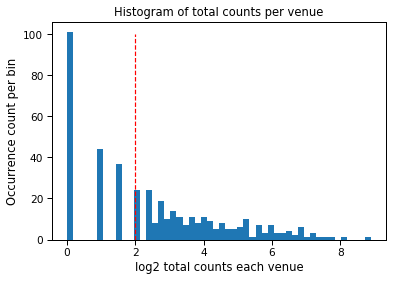

In [56]:
column_sums = all_grouped.sum(axis=0).sort_values(ascending=True)

fig, ax = plt.subplots()
ax.hist(np.log2(column_sums.values), bins=50)
ax.vlines(np.log2(4), ymin=0, ymax=100, colors='r', linestyles='dashed', label='filtering cutoff')
ax.set_ylabel('Occurrence count per bin')
ax.set_xlabel('log2 total counts each venue')
ax.set_title('Histogram of total counts per venue')

plt.savefig("_".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, 
                      "histogram_counts_per_venue.png"]), dpi=300, bbox_inches='tight')

#### Draw histogram of total log2 transformed counts across neighbourhoods

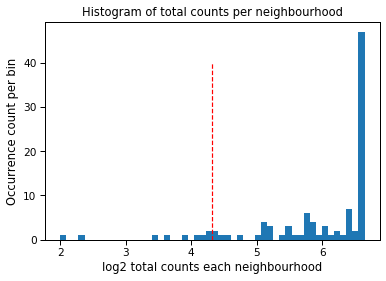

In [57]:
row_sums = all_grouped.sum(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots()
ax.hist(np.log2(row_sums.values), bins=50)
ax.vlines(np.log2(20), ymin=0, ymax=40, colors='r', linestyles='dashed', label='filtering cutoff')
ax.set_ylabel('Occurrence count per bin')
ax.set_xlabel('log2 total counts each neighbourhood')
ax.set_title('Histogram of total counts per neighbourhood')

plt.savefig("_".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, 
                      "histogram_counts_per_neighbourhood.png"]), dpi=300, bbox_inches='tight')

#### Filter out low-count venues and neighbourhoods

In [58]:
# keep only venues with total count of more than 4
columns_keep = column_sums[column_sums > 4]
all_grouped_filtered = all_grouped[columns_keep.index]

# keep only neighbourhoods with total count of more than 20
row_keep = row_sums[row_sums > 20]
all_grouped_filtered = all_grouped_filtered[all_grouped_filtered.index.isin(row_keep.index)]

print(all_grouped_filtered.shape)

(91, 216)


#### Normalise and scale data

In [59]:
# normalise to total neighbourhood counts + scale to counts per 10000 counts
all_grouped_norm = all_grouped_filtered.div(all_grouped_filtered.sum(axis=1), axis=0) * 10000
print(all_grouped_norm.shape)
all_grouped_norm.head()

(91, 216)


,Karaoke Bar,Music Store,Sake Bar,Library,Residential Building (Apartment / Condo),Opera House,Memorial Site,Public Art,Pedestrian Plaza,Indie Theater,Japanese Curry Restaurant,Filipino Restaurant,Beer Garden,Hobby Shop,Hardware Store,Comic Shop,Hotpot Restaurant,Food & Drink Shop,Airport Service,African Restaurant,Basketball Stadium,Dim Sum Restaurant,Gaming Cafe,Garden Center,Kitchen Supply Store,Frozen Yogurt Shop,Paper / Office Supplies Store,Accessories Store,General Entertainment,Light Rail Station,Persian Restaurant,Hostel,Ethiopian Restaurant,Hawaiian Restaurant,Argentinian Restaurant,Health Food Store,Comfort Food Restaurant,Dumpling Restaurant,Mobile Phone Shop,Metro Station,Pilates Studio,Massage Studio,Malay Restaurant,Flea Market,Lebanese Restaurant,Butcher,Bike Rental / Bike Share,Tennis Court,Building,Antique Shop,Fish Market,Event Space,Office,Australian Restaurant,Record Shop,Stationery Store,Lingerie Store,Snack Place,Warehouse Store,Miscellaneous Shop,Martial Arts School,Thrift / Vintage Store,Beer Store,Peruvian Restaurant,BBQ Joint,Flower Shop,Southern / Soul Food Restaurant,Cuban Restaurant,Brazilian Restaurant,Bistro,Boxing Gym,Fountain,Outdoor Sculpture,Boat or Ferry,Indie Movie Theater,Organic Grocery,Poke Place,Pool,Video Game Store,Roof Deck,Platform,Tailor Shop,Candy Store,Sports Bar,Jewelry Store,Smoke Shop,Market,Toy / Game Store,Health & Beauty Service,Bus Station,Shoe Store,Modern European Restaurant,Discount Store,Noodle House,Irish Pub,Dance Studio,History Museum,Men's Store,Exhibit,Historic Site,Art Museum,Cupcake Shop,Fried Chicken Joint,Train Station,Convenience Store,Middle Eastern Restaurant,Brewery,English Restaurant,Arts & Crafts Store,Taco Place,Performing Arts Venue,Nightclub,Optical Shop,Donut Shop,Bank,Hotel Bar,Monument / Landmark,Creperie,Chocolate Shop,Scenic Lookout,Falafel Restaurant,Food Court,Movie Theater,Women's Store,Pet Store,Garden,Cheese Shop,Tapas Restaurant,Music Venue,Dog Run,Burrito Place,Turkish Restaurant,Trail,Museum,Shopping Mall,Concert Hall,Electronics Store,Speakeasy,Jazz Club,Caribbean Restaurant,Tea Room,Portuguese Restaurant,Boutique,Food Truck,Farmers Market,Cycle Studio,Spanish Restaurant,Bus Stop,Greek Restaurant,Liquor Store,Latin American Restaurant,Lounge,Ramen Restaurant,Diner,Salon / Barbershop,Bubble Tea Shop,Gift Shop,Gourmet Shop,Bagel Shop,Korean Restaurant,Breakfast Spot,Department Store,Playground,Asian Restaurant,Furniture / Home Store,Salad Place,Steakhouse,Beer Bar,Vietnamese Restaurant,Plaza,Sporting Goods Shop,Gastropub,Juice Bar,New American Restaurant,Dessert Shop,Pharmacy,Yoga Studio,Ice Cream Shop,Vegetarian / Vegan Restaurant,Spa,Fast Food Restaurant,Cosmetics Shop,Deli / Bodega,Wine Bar,Mediterranean Restaurant,Wine Shop,Supermarket,Bookstore,Art Gallery,Theater,French Restaurant,Thai Restaurant,Indian Restaurant,Seafood Restaurant,Chinese Restaurant,Burger Joint,Cocktail Bar,Mexican Restaurant,Restaurant,Japanese Restaurant,Sushi Restaurant,Grocery Store,Gym,American Restaurant,Gym / Fitness Center,Sandwich Place,Bar,Clothing Store,Pizza Place,Pub,Park,Bakery,Hotel,Italian Restaurant,Café,Coffee Shop
Neighbourhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
175 5th Avenue NYC,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,101.010101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,101.010101,101.010101,0.0,0.0,0.000000,0.0,0.000000,101.010101,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,101.010101,101.010101,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,

#### Draw barplot of count frequency of top venues in user input neighbourhood

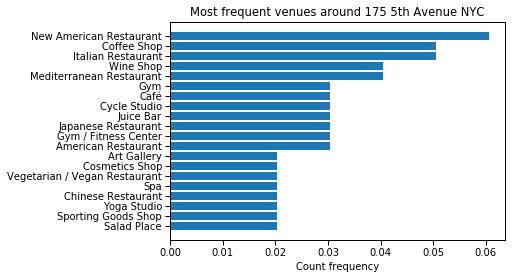

In [60]:
# generate dataframe ranking venues according to their frequency in input neighbourhood
input_grouped_norm = all_grouped_norm[all_grouped_norm.index==user_input_address].transpose()
input_grouped_norm = input_grouped_norm / 10000
input_grouped_norm.sort_values(by=user_input_address, ascending=False, inplace=True)

# draw bar plot of top 20 venue frequency
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fig, ax = plt.subplots()
ax.barh(range(0,20), width=input_grouped_norm[user_input_address][0:20], tick_label=input_grouped_norm.index[0:20])
ax.invert_yaxis()
ax.set_xlabel('Count frequency')
ax.set_title(" ".join(['Most frequent venues around', user_input_address]))

plt.savefig("_".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, "top_venues.png"]), dpi=300,
           bbox_inches='tight')

## 3. Hierarchical clustering

In [61]:
# create dataframe containing all neighbourhoods + cities
anno = address_loc[['Neighbourhood', 'City']]
anno = anno.append(sf_data[['Neighbourhood', 'City']])
anno = anno.append(newyork_data[['Neighbourhood', 'City']])
anno = anno.append(toronto_data[['Neighbourhood', 'City']])
anno = anno.append(london_data[['Neighbourhood', 'City']]).reset_index(drop=True)

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


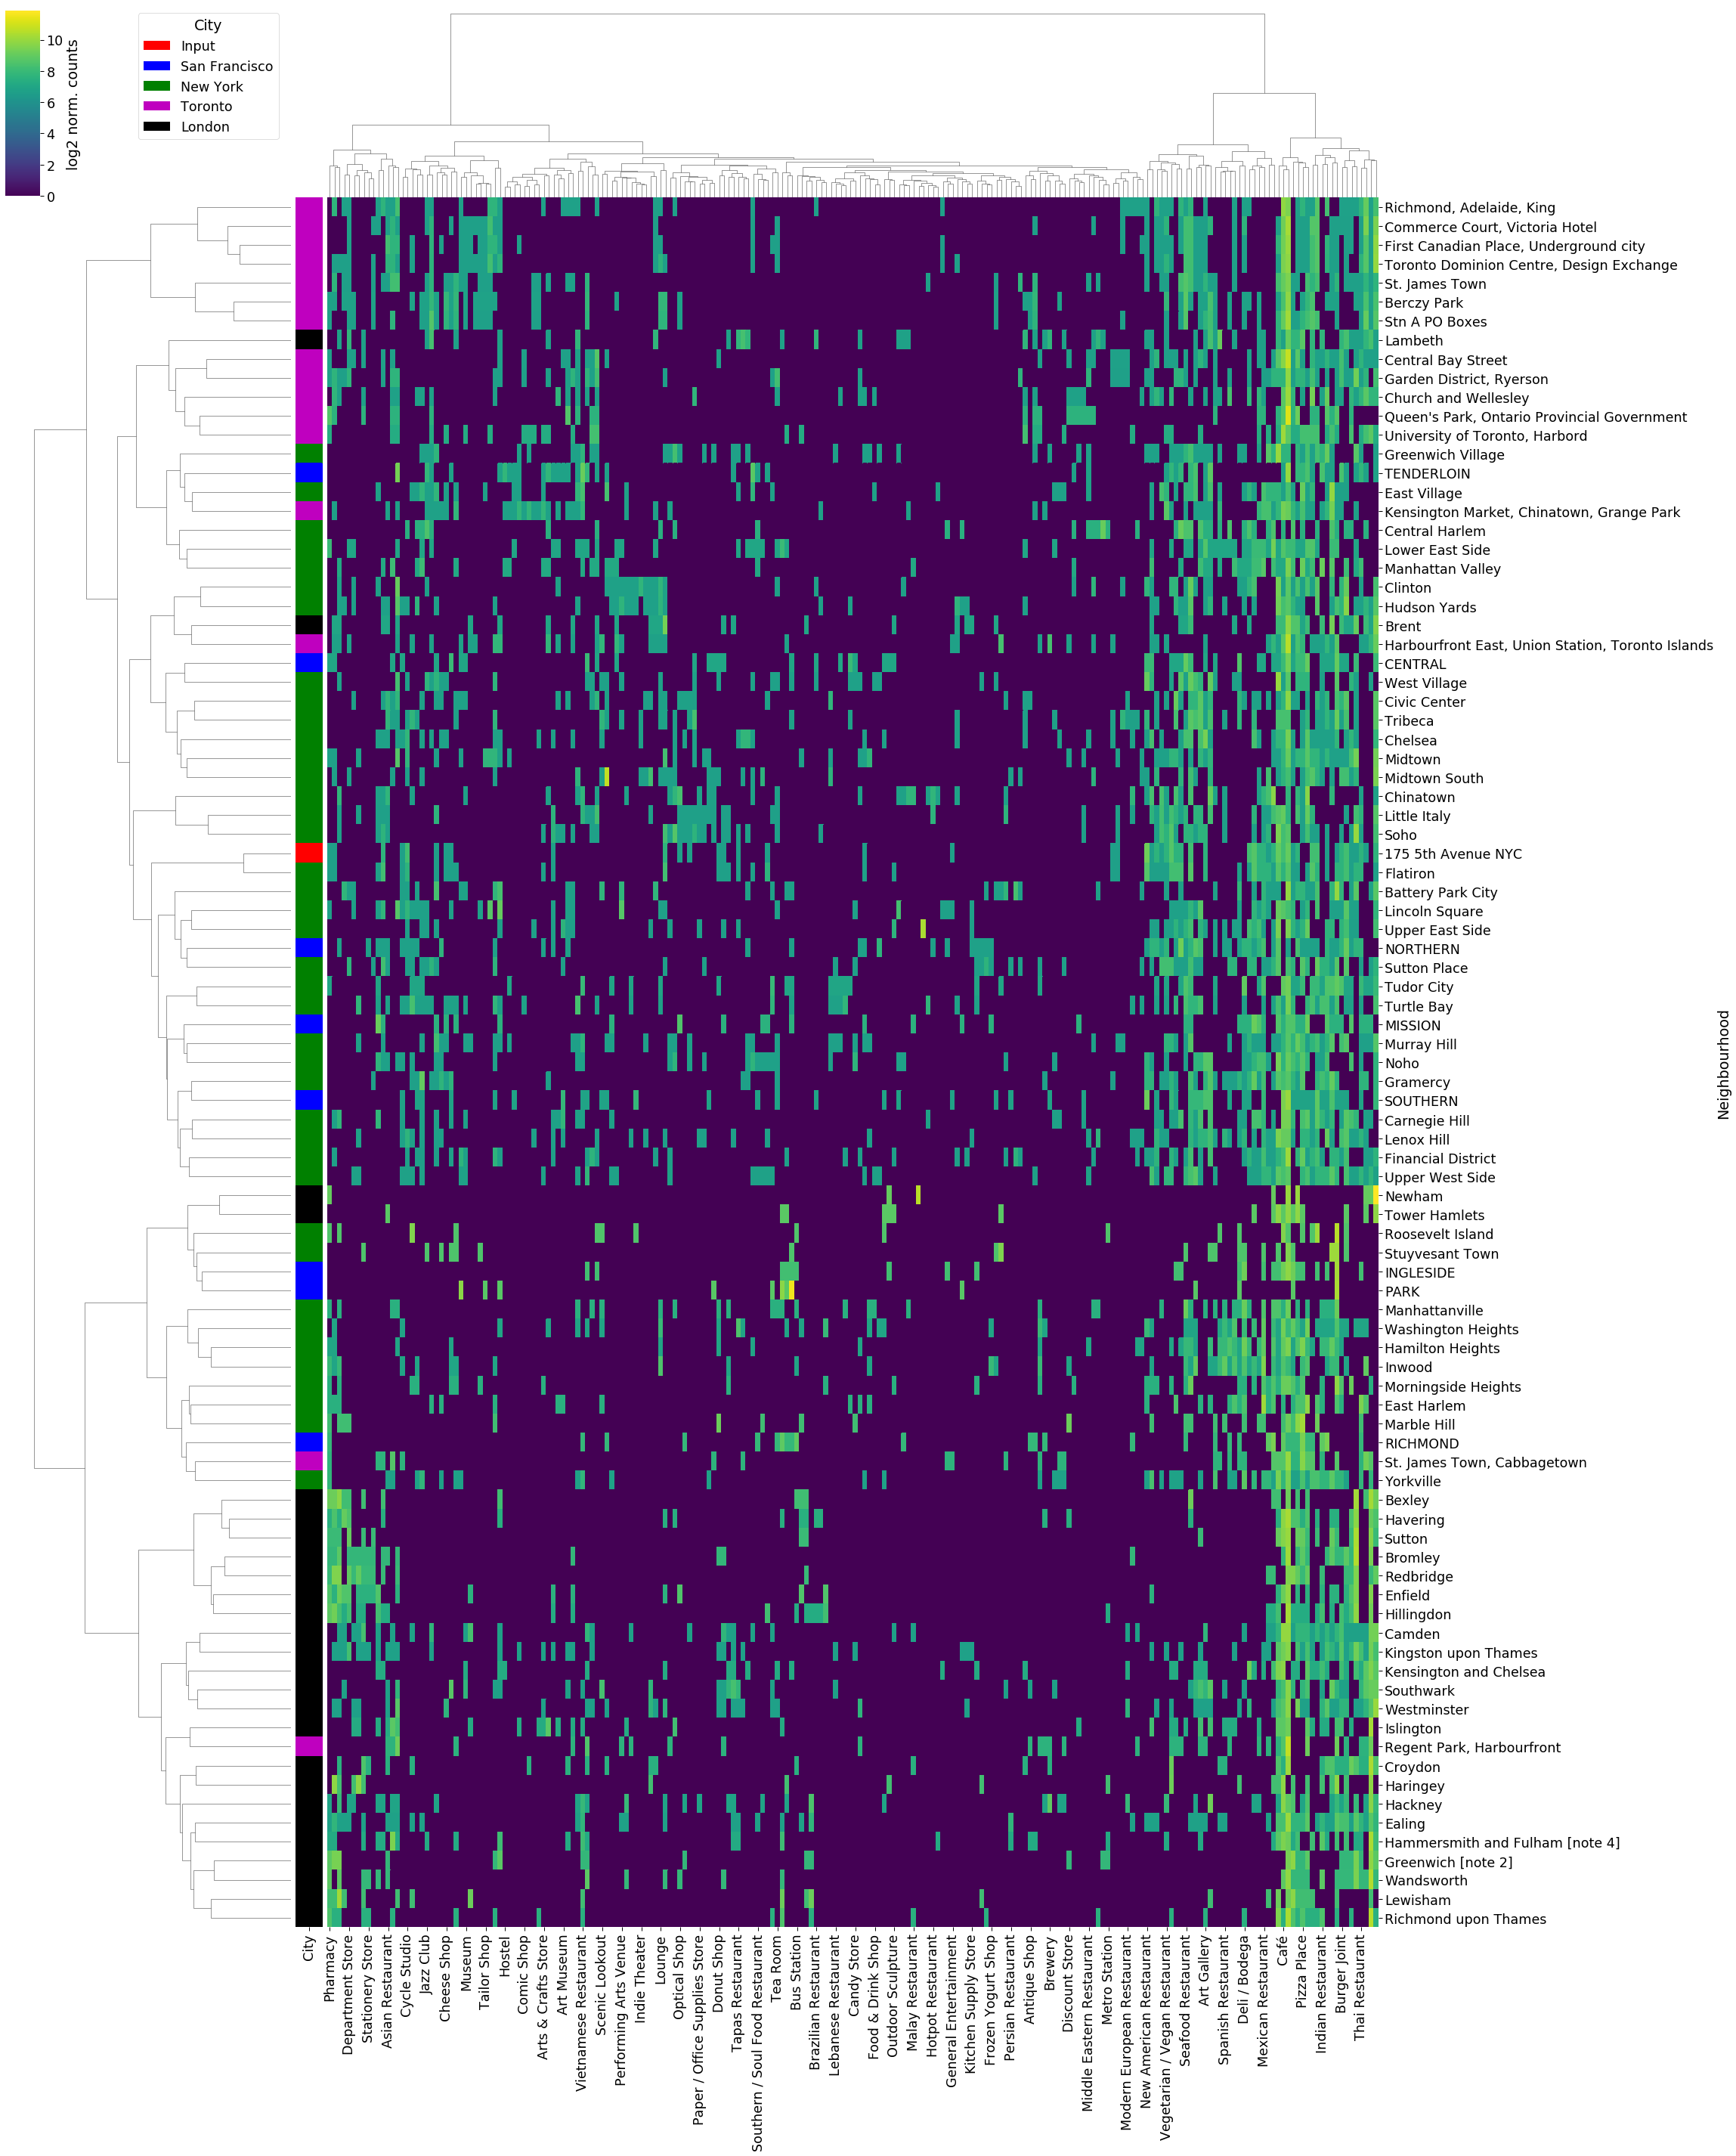

In [62]:
# create row colour annotation for heatmap
lut = dict(zip(anno['City'].unique(), ['r','b','g','m','k']))
row_colors = pd.DataFrame(anno['City'].map(lut))
row_colors.index = anno['Neighbourhood']

# draw seaborn clustermap of neighbourhoods hierarchically clustered according to normalised venue counts
sns.set_context("paper", font_scale=2) 
g = sns.clustermap(np.log2(all_grouped_norm + 1), figsize=(32,40), method='ward', metric='euclidean',
                   cbar_kws={'label': 'log2 norm. counts'}, cbar_pos=(.0,.905,.02,.085), colors_ratio=0.02,
                   dendrogram_ratio=(.2,.1), cmap="viridis", row_colors=row_colors)

# add legend for row annotation
for city in anno['City'].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[city],
                            label=city, linewidth=0)
g.ax_col_dendrogram.legend(title='City', loc=(-.18,.3), ncol=1)

g.savefig("_".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, "clustermap.png"]))

#### Compare sample correlation to sample distances (normalised or log2 + normalised counts) + rank neighbourhoods on similarity to user input address

The correlation ranking correlates better with the distance ranking that is not log2 transformed:
rank_dist_norm    0.852222
rank_dist_log2    0.664676
rank_corr         1.000000
Name: rank_corr, dtype: float64


C:\Users\Micha\anaconda3\lib\site-packages\seaborn\matrix.py:1165: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


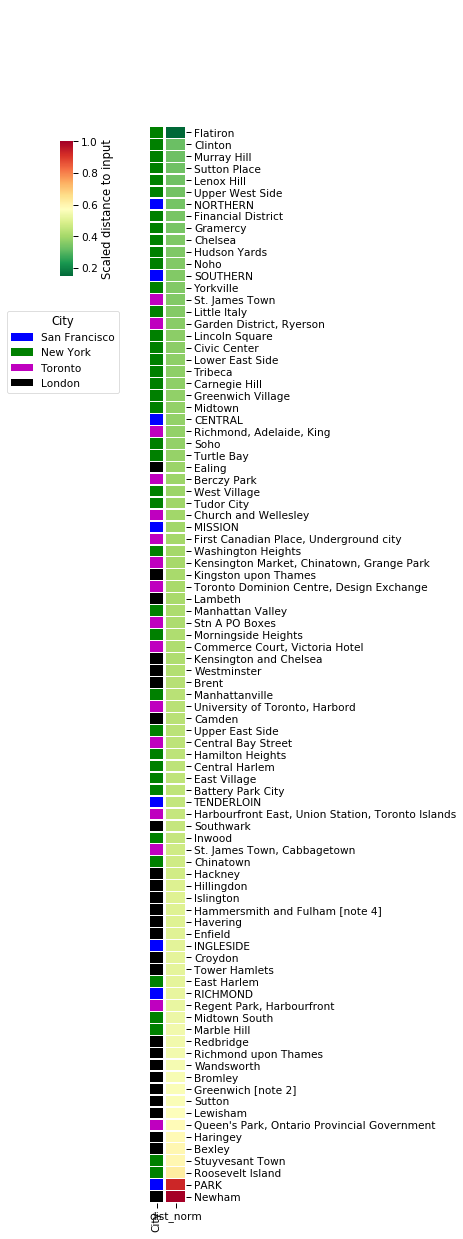

In [63]:
# create correlation matrix of normalised venue counts
all_grouped_norm_corr = pd.DataFrame(all_grouped_norm.transpose().corr(method='pearson'))

# create distance matrix of normalised venue counts
all_grouped_norm_dist = pd.DataFrame(distance_matrix(all_grouped_norm, all_grouped_norm), 
                                     index=all_grouped_norm.index, columns=all_grouped_norm.index)

# create distance matrix of log2 normalised venue counts
all_grouped_log2_norm_dist = pd.DataFrame(distance_matrix(np.log2(all_grouped_norm + 1), np.log2(all_grouped_norm + 1)), 
                                     index=all_grouped_norm.index, columns=all_grouped_norm.index)


# subset to pairwise comparisons of input address with remaining neighbourhoods
input_dist_corr = pd.DataFrame(all_grouped_norm_corr[user_input_address])
input_dist_corr.index = all_grouped_log2_norm_dist.index
input_dist_corr.columns = ['corr']

# use min-max scaling to scale distances
scaler = MinMaxScaler()
input_dist_corr['dist_norm'] = scaler.fit_transform(pd.DataFrame(all_grouped_norm_dist[user_input_address]))
input_dist_corr['dist_log2'] = scaler.fit_transform(pd.DataFrame(all_grouped_log2_norm_dist[user_input_address]))


# add ranked positions for each condition
input_dist_corr = input_dist_corr.sort_values(by='dist_norm', ascending=True)
input_dist_corr['rank_dist_norm'] = range(1,input_dist_corr.shape[0]+1)
input_dist_corr = input_dist_corr.sort_values(by='dist_log2', ascending=True)
input_dist_corr['rank_dist_log2'] = range(1,input_dist_corr.shape[0]+1)
input_dist_corr = input_dist_corr.sort_values(by='corr', ascending=False)
input_dist_corr['rank_corr'] = range(1,input_dist_corr.shape[0]+1)

# check with which distance-based ranking the correlation-based ranking correlates best
print('The correlation ranking correlates better with the distance ranking that is not log2 transformed:') 
print(pd.DataFrame(input_dist_corr.corr())['rank_corr'].iloc[3:6])

input_dist_corr.sort_values(by='rank_dist_norm', inplace=True)
input_dist_corr['Neighbourhood'] = input_dist_corr.index
input_dist_corr.index.name = None 


# draw seaborn heatmap of scaled normalised distances
sns.set_context("paper", font_scale=1.2)
g1 = sns.clustermap(input_dist_corr[['dist_norm']][1:],
                    figsize=(.7,22), row_cluster=False, col_cluster=False,
                    cbar_kws={'label': 'Scaled distance to input'}, cbar_pos=(-1.6,.71,.25,.085), colors_ratio=0.4, 
                    dendrogram_ratio=(.01,.01), cmap="RdYlGn_r", row_colors=row_colors, linewidths=0.3)

# add legend for row annotation
for city in anno['City'].unique()[1:]:
    g1.ax_col_dendrogram.bar(0, 0, color=lut[city],
                            label=city, linewidth=0)
g1.ax_col_dendrogram.legend(title='City', loc=(-7.8,-34.5), ncol=1)

g1.savefig("_".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, "distance_map.png"]))

#### Draw folium maps of neighbourhoods
#### Markers are coloured according to similarity with user input neighbourhood: green = very similar, red = very dissimilar, grey = filtered out due to low venue count 

In [64]:
# function to draw folium map with neighbourhood markers, colour fill according to normalised venue count distance
def folium_map_distances(neighbourhood_data, out_name, latitude, longitude, zoom):

    map_data_dist = neighbourhood_data.merge(input_dist_corr, on='Neighbourhood', how='left')
    
    ## create colour labels from normalised distance values     
    # add colour as determined by distance value
    # colour range is determined by all neighbourhood distance entries except input
    m = cm.ScalarMappable(norm=colors.Normalize(vmin=min(input_dist_corr['dist_norm'][1:]), 
                                                vmax=max(input_dist_corr['dist_norm'][1:])), cmap=cm.RdYlGn_r)
    dist_values = map_data_dist['dist_norm']
    map_fill = []
    for i in range(len(dist_values)):
        # assign grey colour if no distance value available
        if np.isnan(dist_values[i]):
            map_fill.append(colors.rgb2hex((0.5, 0.5, 0.5)))
        else:
            map_fill.append(colors.rgb2hex(m.to_rgba(dist_values[i])))
    
    map_data_dist['fill'] = map_fill
    
    # create map using latitude and longitude values
    map_folium = folium.Map(location=[latitude, longitude], zoom_start=zoom)

    # add markers to map
    for lat,lng,hood,dist,fill in zip(map_data_dist['Latitude'], map_data_dist['Longitude'], 
                                  map_data_dist['Neighbourhood'], map_data_dist['dist_norm'], map_data_dist['fill']):
        # create text for popup labels
        if np.isnan(dist):
            label_text = " - ".join([hood, "distance to input not computed due to low venue count"])
        else:
            label_text = ": ".join([" - ".join([hood, "scaled distance to input (0=lowest, 1=highest)"]), str(dist)])

        label = folium.Popup(label_text, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=9,
            popup=label,
            color='blue',
            fill=True,
            fill_color=fill,
            fill_opacity=0.99,
            parse_html=False).add_to(map_folium)  
        
    map_folium.save("".join(["D:\\Coursera\\Applied Data Science Capstone\\", user_input_address, 
                             "_", out_name, ".html"]))
    
    return(map_folium)

In [65]:
folium_map_distances(address_loc, 'input_address_folium_map', latitude=address_loc.loc[:,'Latitude'][0], 
                     longitude=address_loc.loc[:,'Longitude'][0], zoom=13)

In [66]:
folium_map_distances(sf_data, 'sanfrancisco_folium_map', latitude=37.77, longitude=-122.42, zoom=12)

In [67]:
folium_map_distances(newyork_data, 'newyork_folium_map', latitude=40.79, longitude=-73.95, zoom=11)

In [68]:
folium_map_distances(toronto_data, 'toronto_folium_map', latitude=43.6532, longitude=-79.3832, zoom=13)

In [69]:
folium_map_distances(london_data, 'london_folium_map', latitude=51.509865, longitude=-0.118092, zoom=10)